In [ ]:
import torch
class KernelLogisticRegression:
    def __init__(self, kernel_fn, lam, gamma):
        self.kernel_fn = kernel_fn
        self.lam = lam
        self.gamma = gamma
        self.a = None
        self.X_train = None
    
    def score(self, X, recompute_kernel):
    # X: shape [n_new, d]
        if not recompute_kernel or self.X_train is None:
            raise ValueError("Model has not been trained or X_train is missing.")
        K = self.kernel_fn(X, self.X_train, self.gamma)  # shape: [n_new, m]
        return (K @ self.a).squeeze()  # shape: [n_new]

    def fit(self, X, y, m_epochs, lr):
        self.X_train = X
        m = X.shape[0]
        
        self.a = torch.zeros(m, 1)

        K = self.kernel_fn(X, X, self.gamma)  # shape: [m, m]

        grad = self.a + self.lam * torch.sign(self.a)
        self.a -= lr * grad

        for _ in range(m_epochs):
            # Compute scores: s = K^T @ a
            s = K.T @ self.a  # shape: [m, 1]

            # Binary cross entropy loss
            sigma_s = torch.sigmoid(s)
            loss = -torch.mean(y * torch.log(sigma_s + 1e-8) + (1 - y) * torch.log(1 - sigma_s + 1e-8))

            # Add L1 regularization
            loss += self.lam * torch.norm(self.a, p=1)

    def predict_proba(self, X):
        K = self.kernel_fn(X, self.X_train, self.gamma)  # shape: [new_n, train_n]
        s = K @ self.a.detach()  # shape: [new_n, 1]
        return torch.sigmoid(s)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).float()

# Positive-definite Kernel Function Definition
Now that we have created a kernelized logistic regression, we need some kernel function to test our implementation. For this, I will define one of the most widely utilized kernel functions, the RBF kernel, down below:

In [32]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

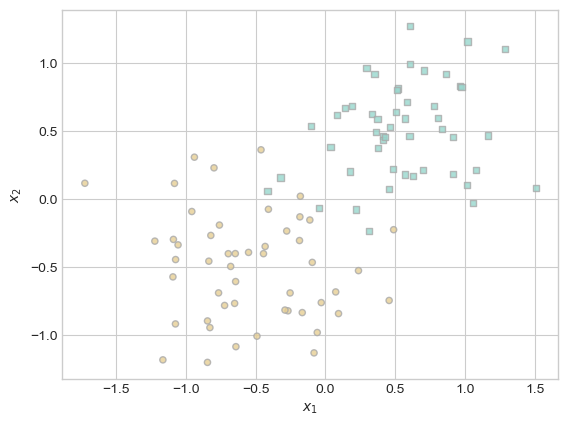

In [33]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

In [34]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

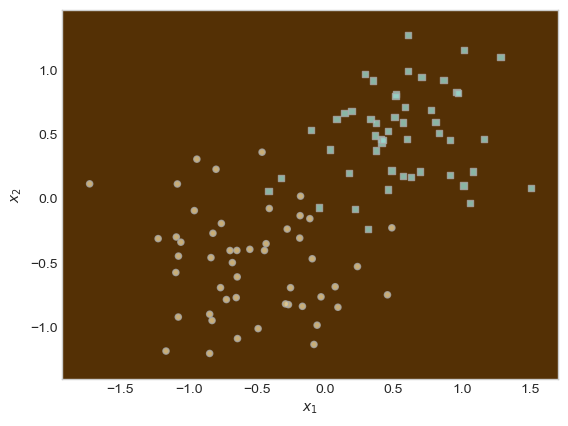

In [38]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
# plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

# Demonstrating Kernelized Logistic Regression on Data
Now that we have fully implemented our kernelized logistic regression and created a scatterplot data, we can demonstrate how the model fits to the data.

# Experiments
We will use our implmentation of kernelized logistic regression in a variety of ways to demonstrate it 

## 1: λ Is Large

In [ ]:
KR = KernelLogisticRegression(rbf_kernel, lam = 100, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
# plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

## 2: Changing γ

In [ ]:
# Have an array of multiplee gamma values and show the wiggle
gamma = []

## 3: Kernel Methods on Nonlinear Patterns